# Processing Data and Plotting Descriptors Examples

#### This notebook demonstrates the power of the package, and its ability to clean battery cycling data, build a model fit individualized to every cycle, and gather peak descriptors. This notebook will use data from the CALCE website: https://www.calce.umd.edu/batteries/data.htm. The package is able to process data from MACCOR cyclers as well, but for the purpose of this notebook we will demonstrate the functionality using the CALCE data. 

### First we import everything we need:

In [1]:
import chachifuncs as ccf
import databasefuncs as dbfs
import databasewrappers_forjupyter as dbfj
import itertools
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import peakutils
import scipy
import sqlite3 as sql

%matplotlib inline

## Processing Data Through the Notebook

### We apply the process_data function, which takes raw data and cleans it, builds and fits a model, and generates cycle descriptors

Filename must not have "Cycle" anywhere in it- as this is how the program splits up cycle numbers later on. 

A few print messages should appear while this function is running: 
1. That database doe not exist-creating it now (only if the database doesn't exist yet).
2. Processing that data.
3. All data separated into cycles and saved in database.  
4. All cycles cleaned and saved in database.  
5. All clean cycles recombined and saved in database.
6. Database updated with descriptors. 

If no peaks were found for a certain cycle, there will be a print message stating so, before indicating the database has been updated with descriptors. 

In [2]:
database = 'init_database3.db'
path = 'data/example_files/ExampleData.xlsx'
datatype = 'Arbin'
username = 'Example User'

#the below is to get the variable filename
filename = path
while '/' in filename:
	filename = filename.split('/', maxsplit = 1)[1]

In [3]:
dbfj.process_data(filename, database, path, datatype, username)

That file name has already been uploaded into the database.


## Now that the raw data has been processed, we can plot it and look at our peak descriptors

In [4]:
# First let's define some variable names
# If you are interested in plotting something other than 
# the file that was just processed, simply change the base_filename
# variable to the file name in the database you wish to plot. 
base_filename = filename.split(".")[0] 
raw_filename = base_filename + "Raw"
model_filename = base_filename + "-ModPoints"
descriptors_filename = base_filename + "ModParams-descriptors"
clean_filename = base_filename + "CleanSet"

#### First let's plot the raw dQ/dV curve of an example cycle, with the model overlaid. 

(-10, 10)

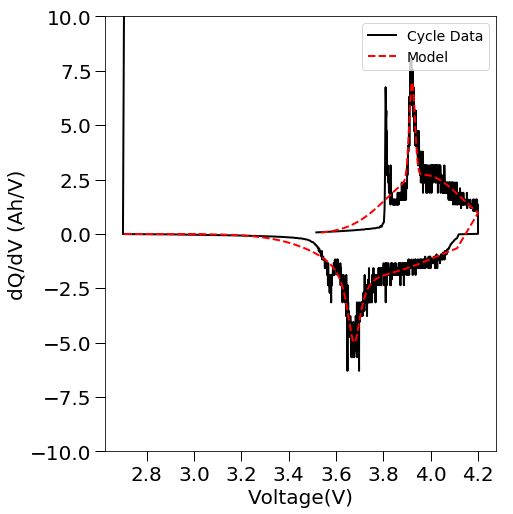

In [5]:
raw_df = dbfs.get_file_from_database(raw_filename, database)
mod_df = dbfs.get_file_from_database(model_filename, database)

fig1 = plt.figure(figsize = (7,8), facecolor = 'w', edgecolor= 'k')
# create the color map based off of the max value in the cycle index column
colors = matplotlib.cm.Greys(np.linspace(0.3, 1, int(max(raw_df['Cycle_Index']))))

cycle_to_plot = 1
# plot cycle 1, this number can be changed to any cycle

for name, group in raw_df.groupby(['Cycle_Index']):
    if name == cycle_to_plot:
        plt.plot(group['Voltage(V)'], group['dQ/dV'], c = 'black', linewidth = 2, label = 'Cycle Data') 

for name, group in mod_df.groupby(['Cycle_Index']): 
    if name == cycle_to_plot:
        plt.plot(group['Voltage(V)'], group['Model'], c = 'red', linewidth = 2, label = 'Model', linestyle = '--')

plt.legend()
leg = plt.legend(loc = 'upper right', fontsize = 14)
plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xlabel('Voltage(V)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)

# plt.xlim(0, 4)
plt.ylim(-10,10)

# Uncomment the following line if you would like to save the plot. 
# plt.savefig(fname = 'MyExampleCycle.png', bbox_inches='tight', dpi = 600)


#### We can also examine how accurate the peak finding was by plotting the curve along with the peak locations and heights:

(-10, 10)

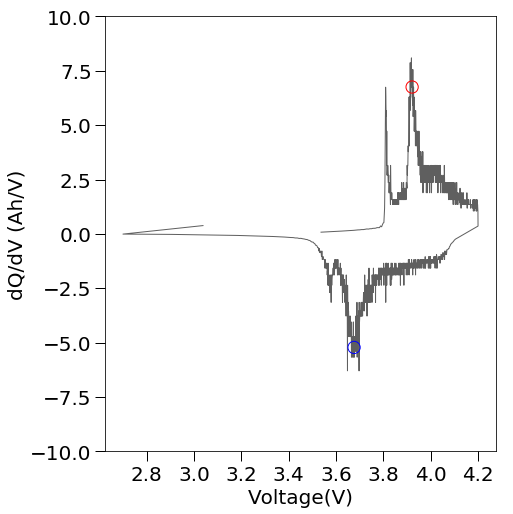

In [6]:
charge_peak_numbers_to_plot = [1, 2, 4]
discharge_peak_numbers_to_plot = [1, 2, 4]

clean_df = dbfs.get_file_from_database(clean_filename, database)
descriptors_df = dbfs.get_file_from_database(descriptors_filename, database)

fig1 = plt.figure(figsize = (7,8), facecolor = 'w', edgecolor= 'k')

# create the color map based off of the max value in the cycle index column
colors = matplotlib.cm.Greys(np.linspace(0.7, 1, int(max(clean_df['Cycle_Index']))))

# create a list of markers to use for each peak
marker_c = itertools.cycle(('o', '*', 'd', 'P', '^', 's')) 
marker_d = itertools.cycle(('o', '*', 'd', 'P', '^', 's')) 

for name, group in clean_df.groupby(['Cycle_Index']):
    # Uncomment the following line if you only want a subset of cycles, and fill in which cycle numbers to plot. 
    # if name == 1 or name == 2:
    plt.plot(group['Voltage(V)'], group['dQ/dV'], c = colors[name-1], linewidth = 1, label = 'Cycle' + str(name)) 

for peak_num in charge_peak_numbers_to_plot: 
    location = "sortedloc-c-" + str(peak_num)
    height = "sortedactheight-c-" + str(peak_num)
    if location in descriptors_df.columns and height in descriptors_df.columns:
        plt.scatter(descriptors_df[location], descriptors_df[height], facecolors = 'none', 
                    edgecolor = 'red', zorder = 5, s = 150, marker = next(marker_c), alpha = 1, 
                    label = 'charge peak ' + str(peak_num))

for peak_num in discharge_peak_numbers_to_plot:
    location = "sortedloc-d-" + str(peak_num)
    height = "sortedactheight-d-" + str(peak_num)
    if location in descriptors_df.columns and height in descriptors_df.columns:
        plt.scatter(descriptors_df[location], -descriptors_df[height], facecolors = 'none', 
                    edgecolor = 'blue', zorder = 5, s = 150, marker = next(marker_d), alpha = 1, 
                    label = 'discharge peak ' + str(peak_num))
    
# for the discharge peak height there has to be a negative sign on the height since the descriptors gathered are an absolute value

plt.ylabel('dQ/dV (Ah/V)', fontsize =20)
plt.xlabel('Voltage(V)', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tick_params(size = 10, width = 1)

# plt.legend()

# plt.xlim(0,1)
plt.ylim(-10,10)

# plt.savefig(fname = 'ExampleWithDescriptors.png', bbox_inches='tight', dpi = 600)

#### Or we may be interested in plotting the peak descriptor values and comparing them over cycles. 

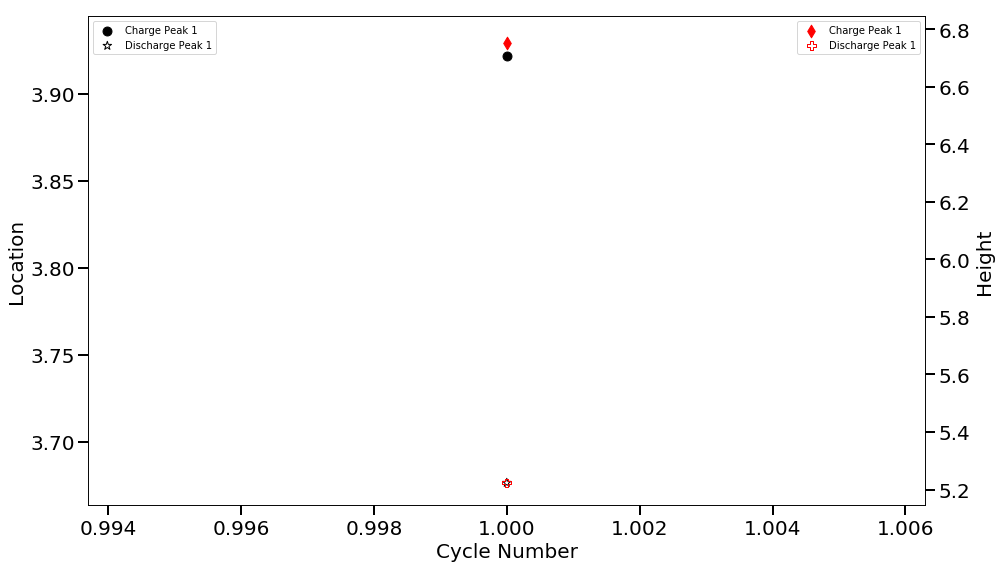

In [7]:
descriptors_df = dbfs.get_file_from_database(descriptors_filename, database)

# The following variables can be filled out to customize the plot
descriptors_to_plot = ["Location", "Height"]
# Can only be two (because only two axes)
# Can be "Location", "Height", "Area", "Sigma", "Amplitude", "FWHM", and/or "Pseudo Voigt Fraction"

charge_peak_numbers_to_plot = [1, 2, 3]
discharge_peak_numbers_to_plot = [1, 2, 3]

# This dictionary is to translate between how the descriptors are saved in the database and how they are typed 
short_hand_dictionary = {"Location": "loc", "Height": "actheight", "Area": "area", "Sigma": "SIGMA", 
                                 "Amplitude": "amplitude", "FWHM": "fwhm", "Pseudo Voigt Fraction": "fraction"}

# Descriptor 1:
descriptor1 = descriptors_to_plot[0]

fig, ax1 = plt.subplots(figsize = (14,8), facecolor = 'w', edgecolor = 'k')
ax1.set_xlabel("Cycle Number", fontsize = 20)
ax1.set_ylabel(descriptor1, fontsize =20)
marker = itertools.cycle(('o', '*', 'd', 'P', '^', 's'))


for peak_num in charge_peak_numbers_to_plot:
    column_name = "sorted" + short_hand_dictionary[descriptor1] + "-c-" + str(peak_num)
    if column_name in descriptors_df.columns:
        ax1.scatter(descriptors_df["c_cycle_number"], descriptors_df[column_name], color = 'black', marker = next(marker), 
                    s = 80, label = "Charge Peak " + str(peak_num))
    ax1.tick_params(size = 10, width = 2, labelsize = 20)

    
for peak_num in discharge_peak_numbers_to_plot:
    column_name = "sorted" + short_hand_dictionary[descriptor1] + "-d-" + str(peak_num)
    if column_name in descriptors_df.columns:
        ax1.scatter(descriptors_df["d_cycle_number"], descriptors_df[column_name], facecolor = 'none', 
                    edgecolors= 'black', marker = next(marker), s = 80, label = "Discharge Peak " + str(peak_num))
    ax1.tick_params(size = 10, width = 2, labelsize = 20)

ax1.legend(loc = "upper left")

# Descriptor 2: 
descriptor2 = descriptors_to_plot[1]

ax2 = ax1.twinx()
ax2.set_ylabel(descriptor2, fontsize =20)

for peak_num in charge_peak_numbers_to_plot:
    column_name = "sorted" + short_hand_dictionary[descriptor2] + "-c-" + str(peak_num)
    if column_name in descriptors_df.columns:
        ax2.scatter(descriptors_df["c_cycle_number"], descriptors_df[column_name], color = 'red', 
                    marker = next(marker), s = 80, label = "Charge Peak " + str(peak_num))
    ax2.tick_params(size = 10, width = 2, labelsize = 20)
    
for peak_num in discharge_peak_numbers_to_plot:
    column_name = "sorted" + short_hand_dictionary[descriptor2] + "-d-" + str(peak_num)
    if column_name in descriptors_df.columns:
        ax2.scatter(descriptors_df["d_cycle_number"], descriptors_df[column_name], facecolor = 'none', 
                    edgecolors = 'red', marker = next(marker), s = 80, label = "Discharge Peak " + str(peak_num))
    ax2.tick_params(size = 10, width = 2, labelsize = 20)

ax2.legend()

    
fig.tight_layout()  
# otherwise the right y-label is slightly clipped

# plt.savefig(fname = 'PeakDescriptorsOverCycles.png', bbox_inches='tight', dpi = 600)


#### Peak area ratios can also be interesting to plot over cycle numbers:

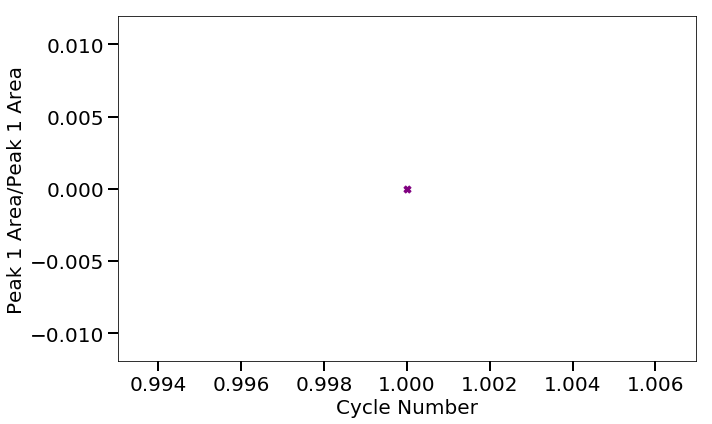

In [8]:
descriptors_df = dbfs.get_file_from_database(descriptors_filename, database)
fig, ax1 = plt.subplots(figsize = (10,6), facecolor = 'w', edgecolor = 'k')

# Put in which two peak numbers we are comparing as the ratios. This is plotted as peak1/peak2 = peak area ratio. 
peak1 = 1
peak2 = 1

ax1.set_ylabel("Peak " + str(peak2) + " Area/" + "Peak " + str(peak1) + " Area", fontsize =20) 
ax1.set_xlabel('Cycle Number', fontsize = 20)
column_name1 = "sortedarea-c-" + str(peak1)

# change the c or d in each of these corresponding to charge (c) or discharge (d)
column_name2 = "sortedarea-d-" + str(peak2)

if column_name1 in descriptors_df.columns and column_name2 in descriptors_df.columns:
    ax1.scatter(descriptors_df['c_cycle_number'], 
                descriptors_df[column_name1]/descriptors_df[column_name2],
                color = 'purple', s = 50, marker = 'X')

#ax1.set_ylim([0, 7])

ax1.tick_params(size = 10, width = 2, labelsize = 20)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# plt.savefig(fname = 'PeakAreaRatios.png', bbox_inches='tight', dpi = 600)

## Adding users to the database and editing passwords

#### Do NOT create a new database here. This is only to add/edit credentials to an existing database, which is necessary through the app. This ability was added for the online version of the tool, where the database cannot be accessed by users. However, an "admin" would like to be able to edit or add new users. 

#### First, set up a dataframe with the valid user and password pairs:

In [9]:
df = pd.DataFrame(data = [['user1', 'password1'], ['user2', 'password2'], ['Example User', 'example password']],
                  columns = ['Username', 'Password'])
df

,Username,Password
0,user1,password1
1,user2,password2
2,Example User,example password


In [10]:
# enter the database you wish to add the username/password pairs to
# this file must already exist or creating it here will lead to  problems adding data to it later
# since it wasn't initalized in the way the code expects

database_name = "MyExampleDatabase.db"
con = sql.connect(database_name)
c = con.cursor()

# add the dataframe created above with the users and passwords to the db
# if a table named "users" already exists, it will be replaced with this one
df.to_sql('users', con, if_exists="replace")
